<a href="https://colab.research.google.com/github/StanleyLiangYork/PytorchCode/blob/main/PyTorch_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GradCAM - Gradient Class Activation Map

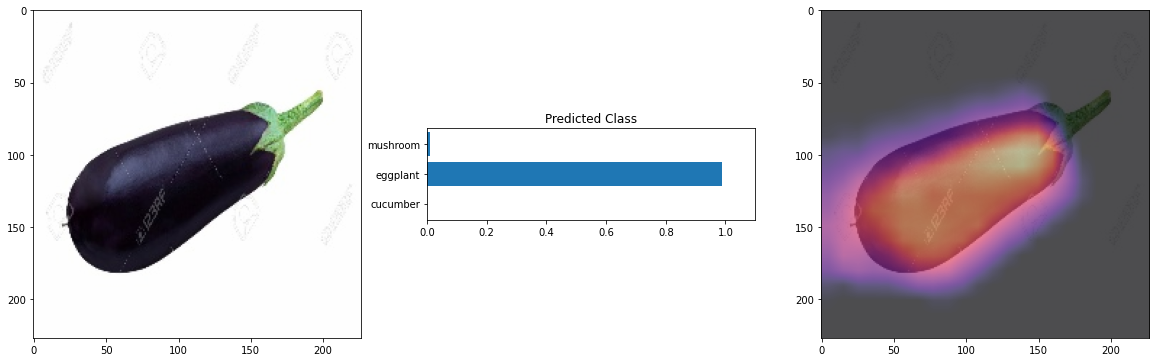

In [ ]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 14.97 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-pdgqb4vo
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-pdgqb4vo
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=8385b1460f87d1a4a3169bd965d8f97b2bfe072910da477fe06e06d8634ef987
  Stored in directory: /tmp/pip-ephem-whee

# Imports

In [ ]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [ ]:
CSV_FILE ='/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'

device = torch.device('cuda')
BATCH_SIZE = 32
EPOCHS=20
LR = 1e-3

In [ ]:
data = pd.read_csv(CSV_FILE)
print(data.shape)
data.head()

(186, 2)


,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [ ]:
# cucumber = 0, eggplant=1, mushoom=2
train_df, test_df = train_test_split(data, test_size=0.2, random_state=100)
print(f'train: {train_df.shape}')
print('test: {}'.format(test_df.shape))

train: (148, 2)
test: (38, 2)


# Augmentations

In [ ]:
train_augments = A.Compose([A.Rotate(),
                            A.HorizontalFlip(p=0.5),
                            A.VerticalFlip(p=0.5),
                            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            ])
# we use the means and stds of the imagenet dataset because we will load the weights trained by imagenet
val_augments = A.Compose([A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Load Image Dataset

In [ ]:
# define the imageDataset class inheriting from torch.utils.data.Dataset

class ImageDataset(Dataset):

    def __init__(self, df, data_dir = None, augs = None,):
        self.df = df
        self.augs = augs
        self.data_dir = data_dir

    # modify the __len__ method from the Dataset class
    def __len__(self):
        return len(self.df)

    # modify the __getitem__ method from the Dataset class
    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        img_path = self.data_dir + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        label = row.label

        if self.augs:
            data = self.augs(image = img)
            img = data['image']
        # from (H,W,C) to (C, H, W) because Pytorch load image as channel first
        img = torch.from_numpy(img).permute(2, 0, 1)

        return img, label

In [ ]:
trainset = ImageDataset(train_df, data_dir=DATA_DIR, augs=train_augments)
valset = ImageDataset(test_df, data_dir=DATA_DIR, augs=val_augments)

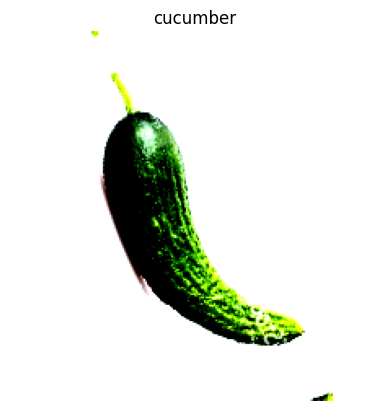

In [ ]:
# try to fetch one image from the training set
image, label =  trainset[1] # get the 2nd image
class_list = ['cucumber', 'eggplant', 'mushoom']
plt.imshow(image.permute(1,2,0))
plt.title(class_list[label])
plt.axis('off')
plt.show()

# can you fetch one image from the test / validation set and plot it?

In [ ]:
print(f"No. of examples in the training set: {len(trainset)}")
print(f"No. of examples in the validation set: {len(valset)}")

No. of examples in the training set: 148
No. of examples in the validation set: 38


# Load Dataset into Batches

In [ ]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valset, batch_size=38) # process in a single batch

In [ ]:
print(f"No. of batches in trainloader : {len(train_loader)}")
print(f"No. of batches in validloader : {len(val_loader)}")

No. of batches in trainloader : 5
No. of batches in validloader : 1


In [ ]:
for images, labels in train_loader:
  break # only  fetch the 1st batch

print(f"One batch image shape : {images.shape}") # batch, channel, height, width
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([32, 3, 227, 227])
One batch label shape : torch.Size([32])


# Create Model

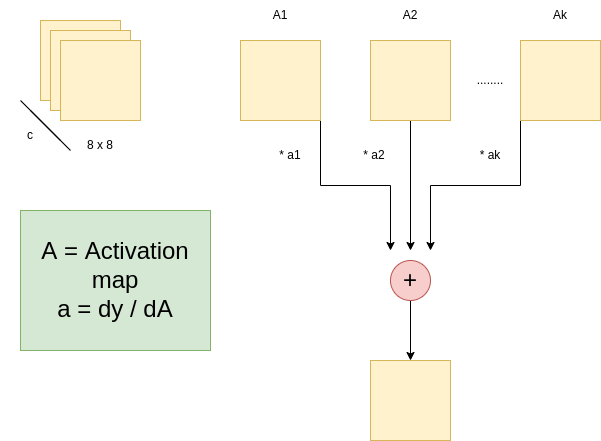

In [ ]:
class ImageDNN(nn.Module):

  def __init__(self):
    super(ImageDNN, self).__init__() # first create the super class

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),
        # 16*
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding=1),
        nn.ReLU(),  )

    self.maxpool = nn.MaxPool2d(kernel_size=(4,4), stride=2)
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=6400, out_features=2048),
        nn.ReLU(),
        nn.Linear(in_features=2048, out_features=3))

    self.gradient = None

  def activations_hook(self, grad):
    self.gradient = grad


  def forward(self, images):
    x = self.feature_extractor(images) # get the feature map
    # register hook is a torch.tensor method to compute a gradient with respect to the pytorch tensor
    # we register the activations_hook as a lambda function
    h = x.register_hook(self.activations_hook)
    x = self.maxpool(x)
    x = self.classifier(x)
    return x


  def get_activation_gradients(self): # get the gradients of acumulative activation outputs: a1, a2, ... ak
    return self.gradient

  def get_activation(self,x):  # get the acumulative activation outputs: A1, A2, ... Ak: 64*10*10
    return self.feature_extractor(x)

In [ ]:
model = ImageDNN()
model.to(device)

ImageDNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

In [ ]:
from torchsummary import summary

summary(model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 225, 225]           1,216
              ReLU-2         [-1, 16, 225, 225]               0
         MaxPool2d-3         [-1, 16, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           6,416
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 53, 53]               0
            Conv2d-7           [-1, 32, 51, 51]          12,832
              ReLU-8           [-1, 32, 51, 51]               0
         MaxPool2d-9           [-1, 32, 24, 24]               0
           Conv2d-10           [-1, 64, 22, 22]          51,264
             ReLU-11           [-1, 64, 22, 22]               0
        MaxPool2d-12           [-1, 64, 10, 10]               0
          Flatten-13                 [-1, 6400]               0
           Linear-14                 [-

# Create Train and Eval function

In [ ]:
def train_fn(dataloader, model, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for images, labels in tqdm(dataloader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def validation_fn(dataloader, model, optimizer, criterion):
  model.eval()
  total_loss = 0.0

  for images, labels in tqdm(dataloader):
    images = images.to(device)
    labels = labels.to(device)

    logits = model(images)
    loss = criterion(logits, labels)


    total_loss += loss.item()

  return total_loss / len(dataloader)

# Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(train_loader, model, optimizer, criterion)
  valid_loss = validation_fn(val_loader, model, optimizer, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best.weights.pt')
    best_valid_loss = valid_loss
    print('Save Weights Successfully')

  print(f'Epoch: {i+1} ==== Train loss: {train_loss} ==== Validation loss: {valid_loss} ')


100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


Save Weights Successfully
Epoch: 1 ==== Train loss: 1.1284091234207154 ==== Validation loss: 0.9912858009338379 


100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


Save Weights Successfully
Epoch: 2 ==== Train loss: 0.8116394281387329 ==== Validation loss: 0.8957831859588623 


100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


Save Weights Successfully
Epoch: 3 ==== Train loss: 0.6642138957977295 ==== Validation loss: 0.789980411529541 


100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


Save Weights Successfully
Epoch: 4 ==== Train loss: 0.5150538086891174 ==== Validation loss: 0.6170802116394043 


100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


Save Weights Successfully
Epoch: 5 ==== Train loss: 0.33786289393901825 ==== Validation loss: 0.30463340878486633 


100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


Epoch: 6 ==== Train loss: 0.3344306945800781 ==== Validation loss: 0.37377429008483887 


100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


Save Weights Successfully
Epoch: 7 ==== Train loss: 0.1746934697031975 ==== Validation loss: 0.07819277048110962 


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


Epoch: 8 ==== Train loss: 0.159576652944088 ==== Validation loss: 0.10151451826095581 


100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


Epoch: 9 ==== Train loss: 0.11567459851503373 ==== Validation loss: 0.10168220847845078 


100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


Save Weights Successfully
Epoch: 10 ==== Train loss: 0.07693997472524643 ==== Validation loss: 0.04261746630072594 


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


Save Weights Successfully
Epoch: 11 ==== Train loss: 0.034924307838082314 ==== Validation loss: 0.03328705579042435 


100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


Save Weights Successfully
Epoch: 12 ==== Train loss: 0.022313076164573432 ==== Validation loss: 0.01891939528286457 


100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


Epoch: 13 ==== Train loss: 0.09160400326363742 ==== Validation loss: 0.036722332239151 


100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


Epoch: 14 ==== Train loss: 0.1218212053179741 ==== Validation loss: 0.08308857679367065 


100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


Epoch: 15 ==== Train loss: 0.06588833956047893 ==== Validation loss: 0.04370604082942009 


100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


Epoch: 16 ==== Train loss: 0.08407359771663322 ==== Validation loss: 0.07171351462602615 


100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


Epoch: 17 ==== Train loss: 0.07128025591373444 ==== Validation loss: 0.05462485924363136 


100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


Epoch: 18 ==== Train loss: 0.06447722557932138 ==== Validation loss: 0.0356232188642025 


100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


Epoch: 19 ==== Train loss: 0.07378025716170669 ==== Validation loss: 0.035381484776735306 


100%|██████████| 1/1 [00:00<00:00, 12.39it/s]

Epoch: 20 ==== Train loss: 0.07569514736533164 ==== Validation loss: 0.1204700618982315 


# Get GradCAM

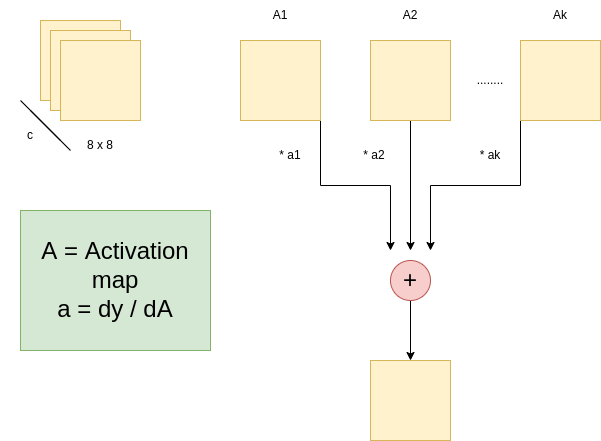

In [ ]:
def get_gradcam(model, image, label, size):
  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim=[0,2,3]) # batch*c*h*w - keep the batch, h, w dims
  activations = model.get_activation(image).detach()

  for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pooled_gradients[i]
    # get the cross-channel mean, keep H and W, get rid of the batch dim
    heatmap = torch.mean(activations, dim=1).squeeze().cpu()
    heatmap = nn.ReLU()(heatmap) # get the activation of the heatmap
    heatmap /= torch.max(heatmap) # scale to (0,1)
    heatmap = cv2.resize(heatmap.numpy(), (size,size))
    return heatmap


In [ ]:
image, label = valset[11] #eggplant-1
denorm_image = image.permute(1,2,0)*np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
image = image.unsqueeze(0).to(device)
pred = model(image)

In [ ]:
heatmap = get_gradcam(model, image, pred[0][1], 227)

In [ ]:
def plot_heatmap(denorm_image, pred, heatmap):

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20,20), ncols=3)

    classes = ['cucumber', 'eggplant', 'mushroom']
    ps = torch.nn.Softmax(dim = 1)(pred).cpu().detach().numpy()
    ax1.imshow(denorm_image)

    ax2.barh(classes, ps[0])
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    ax3.imshow(denorm_image)
    ax3.imshow(heatmap, cmap='magma', alpha=0.7)

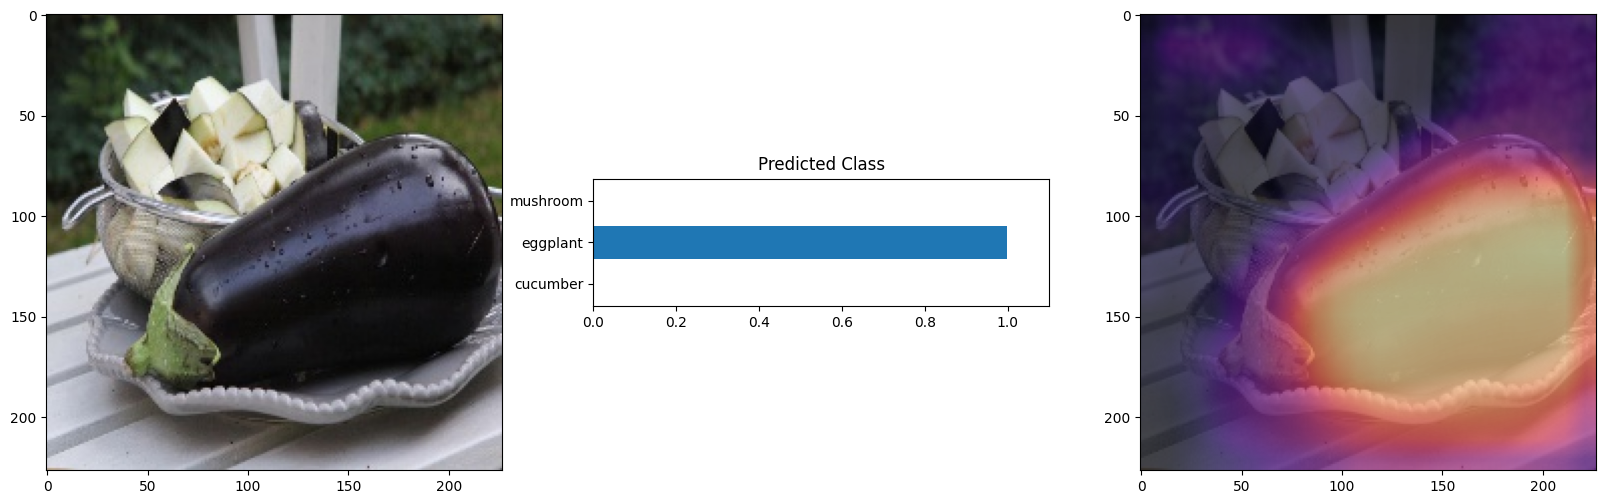

In [ ]:
plot_heatmap(denorm_image, pred, heatmap)